### Process Discovery
We will discover the processes in the system.

1) read the event log
2) filter only to the test events (with the accepted_sessions)
3) understand the amount of traces that exist in the event log
4) discover the process model with trashload to understand the process flow
5) evaluate the performance of the process model using conformance checking


In [106]:
import pandas as pd
import json
import numpy as np
from utils import *
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.visualization.petri_net import visualizer as pn_visualizer

from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.convert import convert_to_petri_net
from pm4py.conformance import precision_token_based_replay, precision_alignments, fitness_token_based_replay, fitness_alignments


In [107]:
with open('accepted_sessions.json', 'r') as f:
    accepted_sessions = json.load(f)

with open('test_sessions.json') as f:
    test_sessions = json.load(f)

total_df = pd.read_csv(FILE, encoding='latin1', delimiter=';')
# Filter the DataFrame to include only the accepted sessions
filtered_df = total_df[total_df['SessionID'].isin([int(session) for session in accepted_sessions])]
test_df = total_df[total_df['SessionID'].isin([int(session) for session in test_sessions])]

/var/folders/27/h86gj_fd3xg23kmxw_95c6kc0000gn/T/ipykernel_8824/3259578819.py:7: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  total_df = pd.read_csv(FILE, encoding='latin1', delimiter=';')


In [108]:
len(filtered_df)

787382

#### Understand the amount of unique traces in the event log

In [109]:
# Step 1: Sort events by session and time
filtered_df = filtered_df.sort_values(by=["SessionID", "TIMESTAMP"])

# Step 2: Group by session and collect the ordered activity list as a tuple
traces = filtered_df.groupby("SessionID")["PAGE_NAME"].apply(tuple)

# Step 3: Count how many times each unique trace occurs
trace_counts = traces.value_counts()

# Step 4: Show top N traces
print(trace_counts.head(10))  # top 10 most common traces

# Total number of unique traces
print("Number of unique traces:", trace_counts.shape[0])

PAGE_NAME
(home,)                  454624
(werkmap,)               125570
(timeout.htm,)            35037
(ww,)                     15351
(onderhoud.htm,)          14925
(vacatures,)              11313
(bijstandsuitkering,)      6114
(home, home)               5365
(Portal (werknemer),)      3941
(Portal (fout),)           3904
Name: count, dtype: int64
Number of unique traces: 4144


In [110]:
TOP_N = 10
df = filtered_df.rename(columns={
    "SessionID": "case:concept:name",
    'PAGE_NAME': "concept:name",
    "TIMESTAMP": "time:timestamp"
})
df = df.dropna(subset=["concept:name"])  # drop NaNs just in case
df["concept:name"] = df["concept:name"].astype(str)  # Ensure action column is string type
df = dataframe_utils.convert_timestamp_columns_in_df(df)

# Convert to EventLog
log = log_converter.apply(df, variant=log_converter.Variants.TO_EVENT_LOG)

# Filter to top N frequent variants
filtered_log = filter_variants_top_k(log, k=TOP_N)

In [111]:
# create a test log for testing
test_df = test_df.rename(columns={
    "SessionID": "case:concept:name",
    'PAGE_NAME': "concept:name",
    "TIMESTAMP": "time:timestamp"
})
test_df = test_df.dropna(subset=["concept:name"])  # drop NaNs just in case
test_df["concept:name"] = test_df["concept:name"].astype(str)  # Ensure action column is string type
test_df = dataframe_utils.convert_timestamp_columns_in_df(test_df)
# Convert to EventLog
test_log = log_converter.apply(test_df, variant=log_converter.Variants.TO_EVENT_LOG)

In [112]:
# display_most_common_actions_from_df(filtered_df)

In [113]:
# display_most_common_actions_from_df(filtered_df, algorithm='heuristics')

In [114]:
# display_most_common_actions_from_df(filtered_df, algorithm='alpha')

### alpha_miner

In [115]:
net, im, fm = alpha_miner.apply(filtered_log)

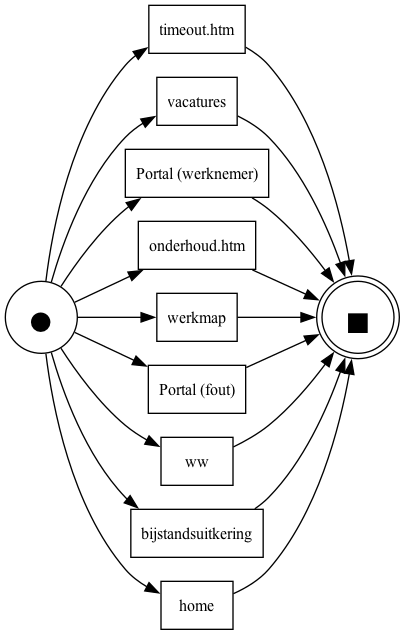

In [116]:
# pt_gviz = pt_visualizer.apply(tree)
# pt_visualizer.view(pt_gviz)
gviz = pn_visualizer.apply(net, im, fm)
pn_visualizer.view(gviz)

In [117]:
# we will conduct conformance checking on the filtered log
fitness_tok = fitness_token_based_replay(test_log, net, im, fm)
print("🎯 Token-based Fitness:", fitness_tok)

fitness_align = fitness_alignments(test_log, net, im, fm)
print("🎯 Alignment-based Fitness:", fitness_align)

precision_tok = precision_token_based_replay(test_log, net, im, fm)
print("🎯 Token-based Precision:", precision_tok    )

precision_align = precision_alignments(test_log, net, im, fm)
print("🎯 Alignment-based Precision:", precision_align)

replaying log with TBR, completed traces ::   0%|          | 0/2578 [00:00<?, ?it/s]

🎯 Token-based Fitness: {'perc_fit_traces': 88.89679036061496, 'average_trace_fitness': 0.8986421045880594, 'log_fitness': 0.9404103513317044, 'percentage_of_fitting_traces': 88.89679036061496}


aligning log, completed variants ::   0%|          | 0/2578 [00:00<?, ?it/s]

🎯 Alignment-based Fitness: {'percFitTraces': 88.41439011926091, 'averageFitness': 0.8965978712233404, 'percentage_of_fitting_traces': 88.41439011926091, 'average_trace_fitness': 0.8965978712233404, 'log_fitness': 0.8873863801189382}


replaying log with TBR, completed traces ::   0%|          | 0/3339 [00:00<?, ?it/s]

🎯 Token-based Precision: 0.9915163342549411


computing precision with alignments, completed variants ::   0%|          | 0/3339 [00:00<?, ?it/s]

🎯 Alignment-based Precision: 1.0


### heuristics_miner

In [118]:
net, im, fm = heuristics_miner.apply(filtered_log, variant=heuristics_miner.Variants.CLASSIC)

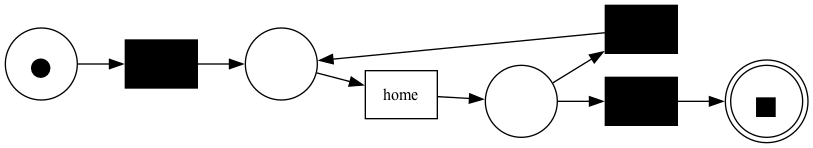

In [119]:
gviz = pn_visualizer.apply(net, im, fm)
pn_visualizer.view(gviz)

In [120]:
# we will conduct conformance checking on the filtered log
fitness_tok = fitness_token_based_replay(test_log, net, im, fm)
print("🎯 Token-based Fitness:", fitness_tok)

fitness_align = fitness_alignments(test_log, net, im, fm)
print("🎯 Alignment-based Fitness:", fitness_align)

precision_tok = precision_token_based_replay(test_log, net, im, fm)
print("🎯 Token-based Precision:", precision_tok    )

precision_align = precision_alignments(test_log, net, im, fm)
print("🎯 Alignment-based Precision:", precision_align)

replaying log with TBR, completed traces ::   0%|          | 0/2578 [00:00<?, ?it/s]

🎯 Token-based Fitness: {'perc_fit_traces': 61.45446597338948, 'average_trace_fitness': 0.6145446597338948, 'log_fitness': 0.8653027941206529, 'percentage_of_fitting_traces': 61.45446597338948}


aligning log, completed variants ::   0%|          | 0/2578 [00:00<?, ?it/s]

🎯 Alignment-based Fitness: {'percFitTraces': 60.698079634521015, 'averageFitness': 0.611739108082466, 'percentage_of_fitting_traces': 60.698079634521015, 'average_trace_fitness': 0.611739108082466, 'log_fitness': 0.607587200998148}


replaying log with TBR, completed traces ::   0%|          | 0/3339 [00:00<?, ?it/s]

🎯 Token-based Precision: 0.9889087359282184


computing precision with alignments, completed variants ::   0%|          | 0/3339 [00:00<?, ?it/s]

🎯 Alignment-based Precision: 0.9999969590166676


### inductive_miner

In [121]:

tree = inductive_miner.apply(filtered_log)

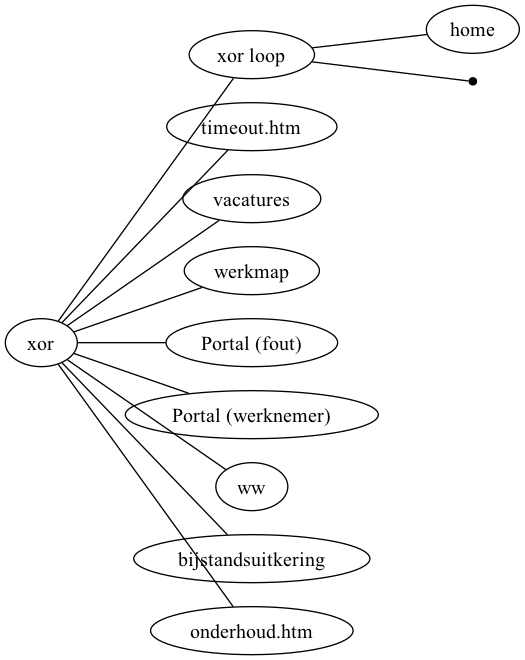

In [122]:
pt_gviz = pt_visualizer.apply(tree)
pt_visualizer.view(pt_gviz)

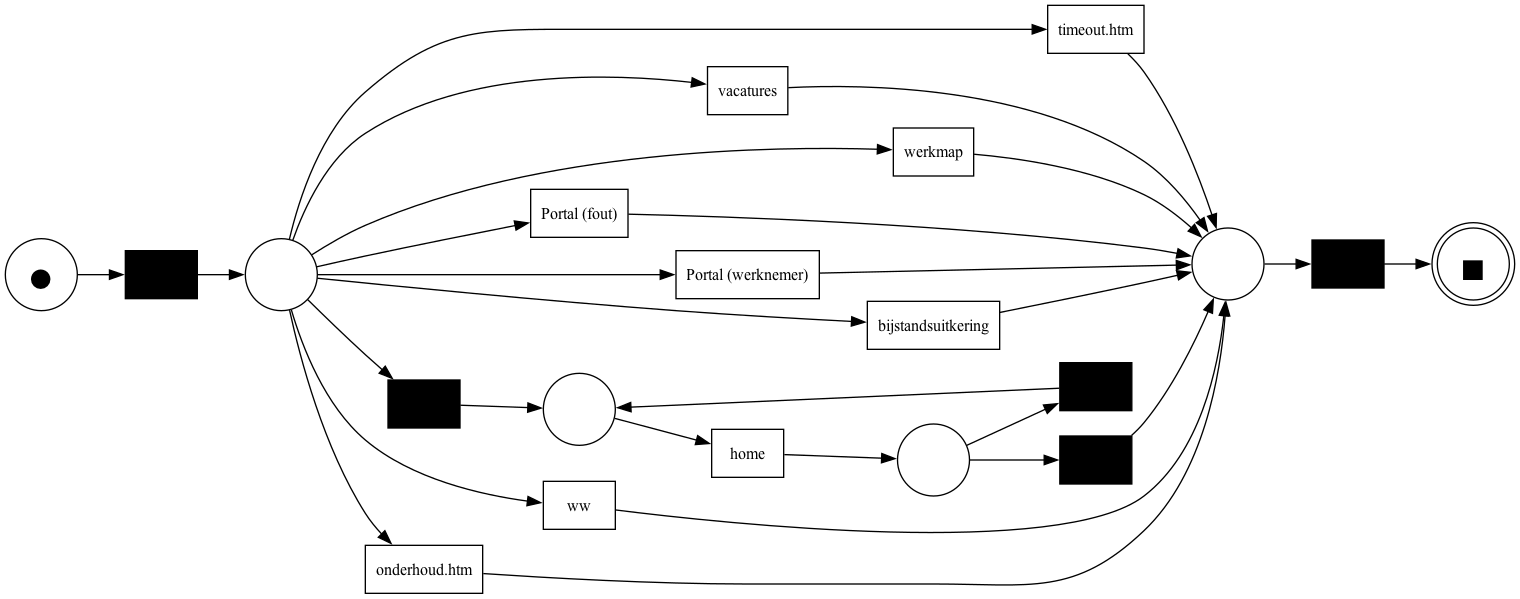

In [123]:
net, im, fm = convert_to_petri_net(tree)
gviz = pn_visualizer.apply(net, im, fm)
pn_visualizer.view(gviz)

In [124]:
# we will conduct conformance checking on the filtered log
fitness_tok = fitness_token_based_replay(test_log, net, im, fm)
print("🎯 Token-based Fitness:", fitness_tok)

fitness_align = fitness_alignments(test_log, net, im, fm)
print("🎯 Alignment-based Fitness:", fitness_align)

precision_tok = precision_token_based_replay(test_log, net, im, fm)
print("🎯 Token-based Precision:", precision_tok    )

precision_align = precision_alignments(test_log, net, im, fm)
print("🎯 Alignment-based Precision:", precision_align)

replaying log with TBR, completed traces ::   0%|          | 0/2578 [00:00<?, ?it/s]

🎯 Token-based Fitness: {'perc_fit_traces': 89.69350499024117, 'average_trace_fitness': 0.9025178204075945, 'log_fitness': 0.9787247375258875, 'percentage_of_fitting_traces': 89.69350499024117}


aligning log, completed variants ::   0%|          | 0/2578 [00:00<?, ?it/s]

🎯 Alignment-based Fitness: {'percFitTraces': 89.1775491481803, 'averageFitness': 0.8993696468117297, 'percentage_of_fitting_traces': 89.1775491481803, 'average_trace_fitness': 0.8993696468117297, 'log_fitness': 0.8916579164326903}


replaying log with TBR, completed traces ::   0%|          | 0/3339 [00:00<?, ?it/s]

🎯 Token-based Precision: 0.9912338199866877


computing precision with alignments, completed variants ::   0%|          | 0/3339 [00:00<?, ?it/s]

🎯 Alignment-based Precision: 0.9999996584131309
